### Read through each step and run the code in order.




### 0 - Includes and constants
    
Display original image in either BGR | RGB | HSV

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from copy import deepcopy

# Read the image
IMAGE_FILE = cv2.imread("sample_maze_3.jpg")

# Parameters for the grid
rows = 5  # Number of rows of nodes
cols = 9  # Number of columns of nodes
node_radius = 5  # Radius of the nodes 


# Start and end position
start_position = [0, 0, "W"]
end_position = [0, 8]

### 1 - Crop image

Use mouse to select cropped area, hit 's' to save the image. Hit 'esc' to exit.

Crop ON the edge or INSIDE the edge.

Image saved as 'cropped_maze.jpg'


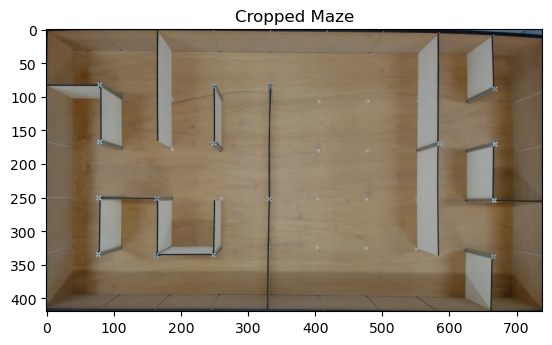

In [2]:
# Resize the image to half its original size
height, width = IMAGE_FILE.shape[:2]
original_image = cv2.resize(IMAGE_FILE, (width // 2, height // 2))

# Mouse callback function for selecting the crop area
def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = original_image.copy()
        cv2.rectangle(img_copy, start_point, end_point, (0, 255, 0), 2)
        cv2.imshow('Maze', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        img_copy = original_image.copy()
        cv2.rectangle(img_copy, start_point, end_point, (0, 255, 0), 2)
        cv2.imshow('Maze', img_copy)

# Initialize variables
start_point = (0, 0)
end_point = (0, 0)
selecting = False

# Create a window and set the mouse callback
cv2.namedWindow('Maze')
cv2.setMouseCallback('Maze', mouse_callback)

# Display the image
cv2.imshow('Maze', original_image)

# Wait for key press
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('s'):  # Press 's' to save the cropped image
        if start_point != end_point:
            # Get the region of interest
            roi = original_image[start_point[1]:end_point[1], start_point[0]:end_point[0]]
            # Save the cropped image
            cv2.imwrite('cropped_maze.jpg', roi)
            print("Image saved as 'cropped_maze.jpg'")
        cv2.destroyAllWindows()
        break
    elif key == 27:  # Press 'Esc' to exit without saving
        cv2.destroyAllWindows()
        break

# Load and display the cropped image using matplotlib
cropped_image = cv2.imread('cropped_maze.jpg')
if cropped_image is not None:
    # Convert BGR to RGB
    cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    plt.imshow(cropped_image_rgb)
    plt.title('Cropped Maze')
    plt.show()


### 2 - HSV picker

Find the low and high HSV values in the selected area. 

DO NOT include any area with walls, standoffs or holes. 

Select 3 areas and hit 's' to record average low and high HSV values. Hit 'esc' to exit.

In [3]:
# Load the image
cropped_maze = cv2.imread("cropped_maze.jpg")

# Initialize variables
start_point = (0, 0)
end_point = (0, 0)
selecting = False
regions = []  # List to store selected regions
MAX_AREAS = 3

# Function to calculate the minimum and maximum HSV values of a region
def calculate_hsv_values(img, start_point, end_point):
    # Ensure the start and end points are within the image bounds
    start_x, start_y = start_point
    end_x, end_y = end_point
    if start_x > end_x or start_y > end_y or start_x < 0 or start_y < 0 or end_x > img.shape[1] or end_y > img.shape[0]:
        print("Selected area is out of bounds.")
        return None, None

    # Get the region of interest
    roi = img[start_y:end_y, start_x:end_x]
    if roi.size == 0:
        print("Selected area is empty.")
        return None, None
    
    # Convert the region to HSV
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    min_hsv = np.min(hsv_roi.reshape(-1, 3), axis=0)
    max_hsv = np.max(hsv_roi.reshape(-1, 3), axis=0)
    
    return min_hsv, max_hsv

# Mouse callback function
def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting, regions
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = cropped_maze.copy()
        for region in regions:
            cv2.rectangle(img_copy, region[0], region[1], (0, 255, 0), 2)
        cv2.rectangle(img_copy, start_point, end_point, (0, 255, 0), 2)
        cv2.imshow('Cropped Maze', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        if len(regions) >= MAX_AREAS:
            regions.pop(0)  # Remove the earliest area if the limit is exceeded
        regions.append((start_point, end_point))
        img_copy = cropped_maze.copy()
        for region in regions:
            cv2.rectangle(img_copy, region[0], region[1], (0, 255, 0), 2)
        cv2.imshow('Cropped Maze', img_copy)
        

# Create a window and set the mouse callback
cv2.namedWindow('Cropped Maze')
cv2.setMouseCallback('Cropped Maze', mouse_callback)

# Display the image
cv2.imshow('Cropped Maze', cropped_maze)

# Wait for key press
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('s'):  # Press 's' to save the HSV values
        if regions:
            all_min_hsv = []
            all_max_hsv = []
            for start_point, end_point in regions:
                min_hsv, max_hsv = calculate_hsv_values(cropped_maze, start_point, end_point)
                if min_hsv is not None and max_hsv is not None:
                    all_min_hsv.append(min_hsv)
                    all_max_hsv.append(max_hsv)
            
            if all_min_hsv and all_max_hsv:
                overall_min_hsv = np.round(np.min(all_min_hsv, axis=0), 2)
                overall_max_hsv = np.round(np.max(all_max_hsv, axis=0), 2)
                
                print(f"low_hsv = [{overall_min_hsv[0]}, {overall_min_hsv[1]}, {overall_min_hsv[2]}]")
                print(f"high_hsv = [{overall_max_hsv[0]}, {overall_max_hsv[1]}, {overall_max_hsv[2]}]")
            else:
                print("No valid regions selected.")
        cv2.destroyAllWindows()
        break
    elif key == 27:  # Press 'Esc' to exit without saving
        cv2.destroyAllWindows()
        break

low_hsv = [0, 0, 88]
high_hsv = [165, 209, 162]


### 3 - Create mask based on HSV values


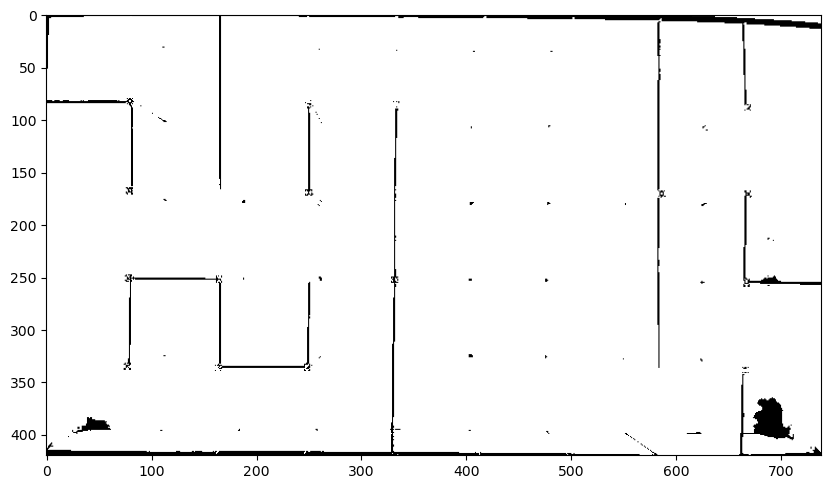

In [4]:
mask_adjust = -10

# Load the image
image = cv2.imread("cropped_maze.jpg")
image_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Create the mask 
mask = cv2.inRange(image_HSV, overall_min_hsv + mask_adjust, overall_max_hsv - mask_adjust)

# sobel_x = cv2.Sobel(mask, cv2.CV_64F, 1, 0, ksize = 3)
# sobel_x = cv2.convertScaleAbs(sobel_x)

# sobel_y = cv2.Sobel(mask, cv2.CV_64F, 0, 1, ksize = 3)
# sobel_y = cv2.convertScaleAbs(sobel_y)

# combined_sobel = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)

# # Define the kernel for morphological operations
# kernel = np.ones((3, 3), np.uint8)

# # Apply erosion followed by dilation (Opening)
# opening = cv2.morphologyEx(combined_sobel, cv2.MORPH_OPEN, kernel)

# # # Apply dilation followed by erosion (Closing) if needed
# # closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

# ret, th = cv2.threshold(opening, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# # # Create the mask
# # mask = cv2.inRange(image_, overall_min_hsv +   mask_adjust, overall_max_hsv - mask_adjust)

# th = cv2.bitwise_not(th)


# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(mask, cmap='gray')
plt.show()

### 4 - Image processing

Tune it using the four variables. 

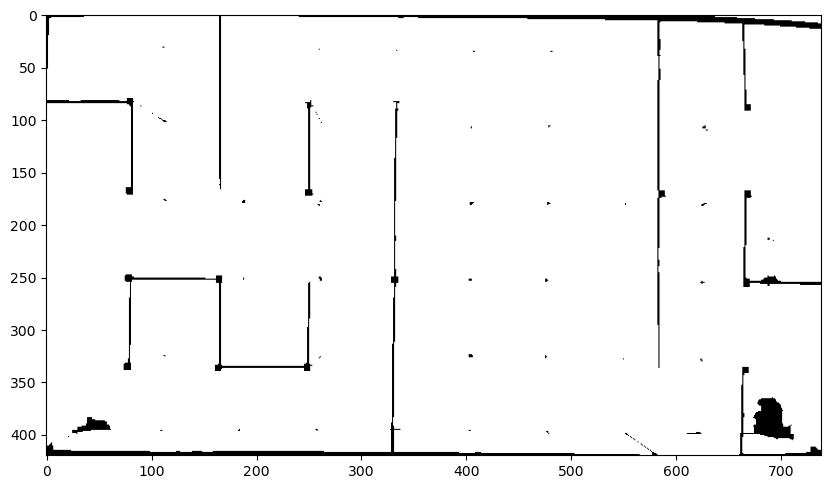

In [5]:
# Parameters for erosion and dilation
erosion_kernel_size = (3, 3)  # Size of the kernel for erosion
dilation_kernel_size = (3, 3)  # Size of the kernel for dilation
iterations_erosion = 2  # Number of erosion iterations
iterations_dilation = 2  # Number of dilation iterations

erosion_kernel = np.ones(erosion_kernel_size, np.uint8)
dilation_kernel = np.ones(dilation_kernel_size, np.uint8)

result = mask

# result = cv2.bitwise_not(mask)


# Perform erosion
result = cv2.erode(result, erosion_kernel, iterations=iterations_erosion)

# Perform dilation
result = cv2.dilate(result, dilation_kernel, iterations=iterations_dilation)



# sobel_x = cv2.Sobel(result, cv2.CV_64F, 1, 0, ksize = 3)
# sobel_x = cv2.convertScaleAbs(sobel_x)

# sobel_y = cv2.Sobel(result, cv2.CV_64F, 0, 1, ksize = 3)
# sobel_y = cv2.convertScaleAbs(sobel_y)

# combined_sobel = cv2.addWeighted(sobel_x, 0.5, sobel_y, 0.5, 0)
# combined_sobel = cv2.bitwise_not(combined_sobel)

# adaptive_binary_image = cv2.adaptiveThreshold(combined_sobel, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#                                               cv2.THRESH_BINARY, 11, 2)
# # ret, th = cv2.threshold(opening, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Save the result image
cv2.imwrite('mask.jpg', result)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(result, cmap='gray')
plt.show()


### 5 - Class for BFS

In [6]:
class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        self.nodes[node_id] = Node(node_id, x, y)
        self.edges[node_id] = []

    def add_edge(self, node_id1, node_id2, weight):
        self.edges[node_id1].append((node_id2, weight))
        self.edges[node_id2].append((node_id1, weight))

    def remove_edge(self, node_id1, node_id2):
        self.edges[node_id1] = [(nid, w) for nid, w in self.edges[node_id1] if nid != node_id2]
        self.edges[node_id2] = [(nid, w) for nid, w in self.edges[node_id2] if nid != node_id1]
    
    def remove_node(self, node_id):
        # Remove edges connected to the node
        if node_id in self.edges:
            for nid in self.edges[node_id]:
                self.remove_edge(node_id, nid[0])
            del self.edges[node_id]
        
        # Remove the node itself
        if node_id in self.nodes:
            del self.nodes[node_id]

            
    def get_nodes(self):
        return self.nodes.keys()
    
    def get_edge_weight(self, node_id1, node_id2):
        for nid, w in self.edges[node_id1]:
            if nid == node_id2:
                return w
        return None

### 6 - Grid and BFS Path planning

Click and drag to select the grid area.

Define starting position as [x, y, heading]. Ending position as [x, y]

Generate the path and display in blue.

Selected area: ((36, 37), (714, 381))


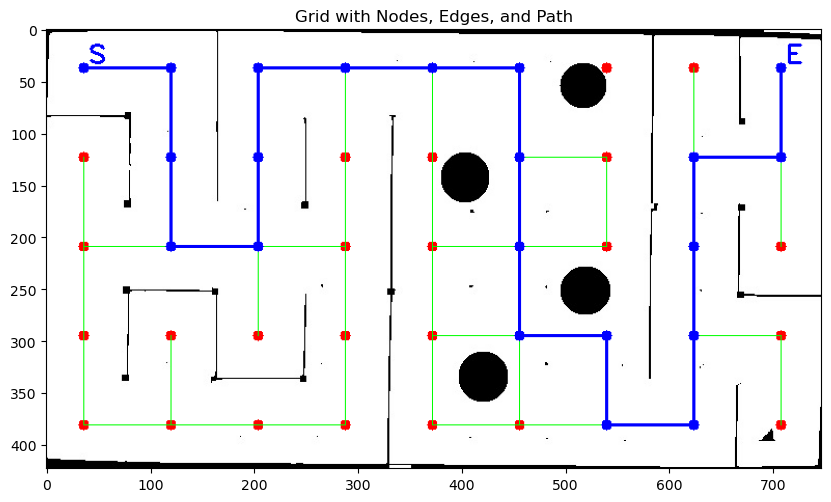

In [7]:
graph = Graph()

# Variable for path width
path_width = 3 

# Parameters for BFS
start_node = (start_position[0], start_position[1])
end_node = (end_position[0], end_position[1])

# Load the mask image (from the previous script)
# result_rgb = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)

# Load the mask image (only use this during debug)
mask = cv2.imread("mask_2.jpg")
result_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
result = result_rgb.copy()


def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting, selected_area
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = result_rgb.copy()
        cv2.rectangle(img_copy, start_point, end_point, (255, 0, 0), 2)
        cv2.imshow('Select Grid Area', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        selected_area = (start_point, end_point)
        print(f"Selected area: {selected_area}")

def create_grid(image_rgb, area, rows, cols):
    (start_x, start_y), (end_x, end_y) = area
    # Calculate grid cell size
    cell_width = (end_x - start_x) // (cols - 1)
    cell_height = (end_y - start_y) // (rows - 1)
    
    grid_image = image_rgb.copy()
    
    # Draw grid nodes as blue dots and create graph nodes
    for i in range(rows):
        for j in range(cols):
            x = start_x + j * cell_width
            y = start_y + i * cell_height
            cv2.circle(grid_image, (x, y), node_radius, (255, 0, 0), -1)
            graph.add_node((i, j), x, y)

    
    # Add edges if all parallel lines in the path are all white
    # for i in range(rows):
    #     for j in range(cols):
    #         x1 = start_x + j * cell_width
    #         y1 = start_y + i * cell_height

    #         # Check vertical edges
    #         if j < cols - 1:
    #             x2 = x1 + cell_width
    #             vertical_path = result[y1-path_width//2:y1+path_width//2, x1:x2]
    #             if np.all(vertical_path == 255):
    #                 graph.add_edge((i, j), (i, j + 1), 1)
    #                 cv2.line(grid_image, (x1, y1), (x2, y1), (0, 255, 0), 1)

    #         # Check horizontal edges
    #         if i < rows - 1:
    #             y2 = y1 + cell_height
    #             horizontal_path = result[y1:y2, x1-path_width//2:x1+path_width//2]
    #             if np.all(horizontal_path == 255):
    #                 graph.add_edge((i, j), (i + 1, j), 1)
    #                 cv2.line(grid_image, (x1, y1), (x1, y2), (0, 255, 0), 1)


    # Add edges if any parallel lines in the path are all white
    for i in range(rows):
        for j in range(cols):
            x1 = start_x + j * cell_width
            y1 = start_y + i * cell_height

            # Check vertical edges
            if j < cols - 1:
                x2 = x1 + cell_width
                vertical_clear = False
                for k in range(-path_width // 2, path_width // 2 + 1):
                    if y1 + k < 0 or y1 + k >= result.shape[0]:  # Boundary check
                        continue
                    vertical_path = result[y1 + k, x1:x2]
                    if np.all(vertical_path == 255):
                        vertical_clear = True
                        break
                if vertical_clear:
                    graph.add_edge((i, j), (i, j + 1), 1)
                    cv2.line(grid_image, (x1, y1), (x2, y1), (0, 255, 0), 1)

            # Check horizontal edges
            if i < rows - 1:
                y2 = y1 + cell_height
                horizontal_clear = False
                for k in range(-path_width // 2, path_width // 2 + 1):
                    if x1 + k < 0 or x1 + k >= result.shape[1]:  # Boundary check
                        continue
                    horizontal_path = result[y1:y2, x1 + k]
                    if np.all(horizontal_path == 255):
                        horizontal_clear = True
                        break
                if horizontal_clear:
                    graph.add_edge((i, j), (i + 1, j), 1)
                    cv2.line(grid_image, (x1, y1), (x1, y2), (0, 255, 0), 1)

    
    return grid_image, graph

def bfs_pathfinding(graph, start_node, end_node):
    queue = deque([start_node])
    came_from = {start_node: None}
    
    while queue:
        current = queue.popleft()
        if current == end_node:
            break
        
        for neighbor, _ in graph.edges.get(current, []):
            if neighbor not in came_from:
                queue.append(neighbor)
                came_from[neighbor] = current
    
    # Reconstruct path
    path = []
    current = end_node
    while current is not None:
        path.append(current)
        current = came_from[current]
    
    path.reverse()
    return path

# Create a window and set the mouse callback
cv2.namedWindow('Select Grid Area')
cv2.setMouseCallback('Select Grid Area', mouse_callback)

# Display the mask image for selecting area
cv2.imshow('Select Grid Area', result_rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()

if 'selected_area' in globals():
    grid_image, graph = create_grid(result_rgb, selected_area, rows, cols)
    
    # Find and highlight the path
    path = bfs_pathfinding(graph, start_node, end_node)
    
    # Draw the path and nodes
    for node in path:
        x, y = graph.nodes[node].get_point()
        cv2.circle(grid_image, (x, y), node_radius, (0, 0, 255), -1)
    
    # Draw edges on the path
    for i in range(len(path) - 1):
        x1, y1 = graph.nodes[path[i]].get_point()
        x2, y2 = graph.nodes[path[i + 1]].get_point()
        cv2.line(grid_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    # Highlight start and end nodes
    start_x, start_y = graph.nodes[start_node].get_point()
    end_x, end_y = graph.nodes[end_node].get_point()
    cv2.circle(grid_image, (start_x, start_y), node_radius, (0, 0, 255), -1)  
    cv2.circle(grid_image, (end_x, end_y), node_radius, (0, 0, 255), -1)  
    cv2.putText(grid_image, 'S', (start_x + node_radius, start_y - node_radius), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    cv2.putText(grid_image, 'E', (end_x + node_radius, end_y - node_radius), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    
    # Display the final grid image with nodes, edges, and path
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_image)
    plt.title('Grid with Nodes, Edges, and Path')
    plt.show()
else:
    print("No area selected. Please run the selection process again.")

### Testing section (Don't run)

Selected area: ((32, 32), (709, 378))
Selected area: ((709, 378), (709, 378))


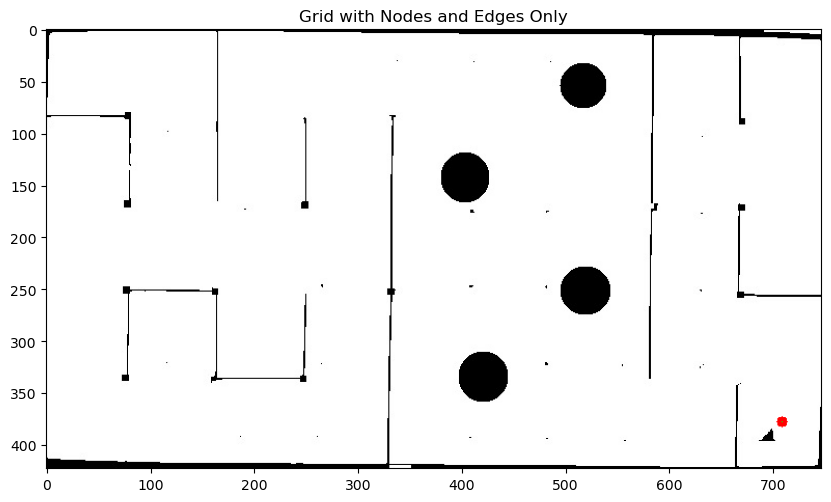

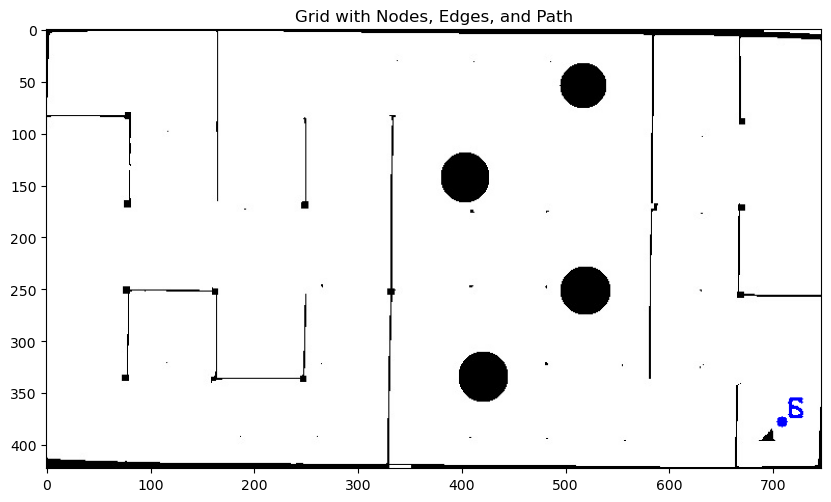

In [8]:
graph = Graph()

# Variable for path width
path_width = 3 

# Parameters for BFS
start_node = (start_position[0], start_position[1])
end_node = (end_position[0], end_position[1])

# Load the mask image (from the previous script)
# result_rgb = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)

# Load the mask image (only use this during debug)
mask = cv2.imread("mask_2.jpg")
result_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
result = result_rgb.copy()

def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting, selected_area
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = result_rgb.copy()
        cv2.rectangle(img_copy, start_point, end_point, (255, 0, 0), 2)
        cv2.imshow('Select Grid Area', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        selected_area = (start_point, end_point)
        print(f"Selected area: {selected_area}")

def create_grid(image_rgb, area, rows, cols):
    (start_x, start_y), (end_x, end_y) = area
    # Calculate grid cell size
    cell_width = (end_x - start_x) // (cols - 1)
    cell_height = (end_y - start_y) // (rows - 1)
    
    grid_image = image_rgb.copy()
    edges_image = image_rgb.copy()

    # Draw grid nodes as blue dots and create graph nodes
    for i in range(rows):
        for j in range(cols):
            x = start_x + j * cell_width
            y = start_y + i * cell_height
            cv2.circle(grid_image, (x, y), node_radius, (255, 0, 0), -1)
            cv2.circle(edges_image, (x, y), node_radius, (255, 0, 0), -1)
            graph.add_node((i, j), x, y)

    # Add edges if any parallel lines in the path are all white
    for i in range(rows):
        for j in range(cols):
            x1 = start_x + j * cell_width
            y1 = start_y + i * cell_height

            # Check vertical edges
            if j < cols - 1:
                x2 = x1 + cell_width
                vertical_clear = False
                for k in range(-path_width // 2, path_width // 2 + 1):
                    if y1 + k < 0 or y1 + k >= result.shape[0]:  # Boundary check
                        continue
                    vertical_path = result[y1 + k, x1:x2]
                    if np.all(vertical_path == 255):
                        vertical_clear = True
                        break
                if vertical_clear:
                    graph.add_edge((i, j), (i, j + 1), 1)
                    cv2.line(grid_image, (x1, y1), (x2, y1), (0, 255, 0), 1)
                    cv2.line(edges_image, (x1, y1), (x2, y1), (0, 255, 0), 1)

            # Check horizontal edges
            if i < rows - 1:
                y2 = y1 + cell_height
                horizontal_clear = False
                for k in range(-path_width // 2, path_width // 2 + 1):
                    if x1 + k < 0 or x1 + k >= result.shape[1]:  # Boundary check
                        continue
                    horizontal_path = result[y1:y2, x1 + k]
                    if np.all(horizontal_path == 255):
                        horizontal_clear = True
                        break
                if horizontal_clear:
                    graph.add_edge((i, j), (i + 1, j), 1)
                    cv2.line(grid_image, (x1, y1), (x1, y2), (0, 255, 0), 1)
                    cv2.line(edges_image, (x1, y1), (x1, y2), (0, 255, 0), 1)

    return grid_image, edges_image, graph

def bfs_pathfinding(graph, start_node, end_node):
    queue = deque([start_node])
    came_from = {start_node: None}
    
    while queue:
        current = queue.popleft()
        if current == end_node:
            break
        
        for neighbor, _ in graph.edges.get(current, []):
            if neighbor not in came_from:
                queue.append(neighbor)
                came_from[neighbor] = current
    
    # Reconstruct path
    path = []
    current = end_node
    while current is not None:
        path.append(current)
        current = came_from[current]
    
    path.reverse()
    return path

# Create a window and set the mouse callback
cv2.namedWindow('Select Grid Area')
cv2.setMouseCallback('Select Grid Area', mouse_callback)

# Display the mask image for selecting area
cv2.imshow('Select Grid Area', result_rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()

if 'selected_area' in globals():
    grid_image, edges_image, graph = create_grid(result_rgb, selected_area, rows, cols)
    
    # Find and highlight the path
    path = bfs_pathfinding(graph, start_node, end_node)
    
    # Draw the path and nodes
    for node in path:
        x, y = graph.nodes[node].get_point()
        cv2.circle(grid_image, (x, y), node_radius, (0, 0, 255), -1)
    
    # Draw edges on the path
    for i in range(len(path) - 1):
        x1, y1 = graph.nodes[path[i]].get_point()
        x2, y2 = graph.nodes[path[i + 1]].get_point()
        cv2.line(grid_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    # Highlight start and end nodes
    start_x, start_y = graph.nodes[start_node].get_point()
    end_x, end_y = graph.nodes[end_node].get_point()
    cv2.circle(grid_image, (start_x, start_y), node_radius, (0, 0, 255), -1)  
    cv2.circle(grid_image, (end_x, end_y), node_radius, (0, 0, 255), -1)  
    cv2.putText(grid_image, 'S', (start_x + node_radius, start_y - node_radius), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    cv2.putText(grid_image, 'E', (end_x + node_radius, end_y - node_radius), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    
    # Display the image with only nodes and edges
    plt.figure(figsize=(10, 10))
    plt.imshow(edges_image)
    plt.title('Grid with Nodes and Edges Only')
    plt.show()
    
    # Display the final grid image with nodes, edges, and path
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_image)
    plt.title('Grid with Nodes, Edges, and Path')
    plt.show()
else:
    print("No area selected. Please run the selection process again.")

### 7 - Generate chain command

Default turning around using "rr"

In [9]:
def generate_robot_commands(path, start_position, end_position):
    directions = ["N", "E", "S", "W"]
    delta = {
        ("N", "E"): 'r',
        ("N", "W"): 'l',
        ("E", "N"): 'l',
        ("E", "S"): 'r',
        ("S", "E"): 'l',
        ("S", "W"): 'r',
        ("W", "N"): 'r',
        ("W", "S"): 'l'
    }
    
    # To handle turning around
    turn_around = {
        "N": "S",
        "E": "W",
        "S": "N",
        "W": "E"
    }
    
    # Initialize variables
    commands = []
    current_position = start_position[:]
    current_direction = start_position[2]
    
    # Process each node in the path
    for i in range(1, len(path)):
        prev_node = path[i - 1]
        curr_node = path[i]
        
        # Determine movement direction
        if curr_node[0] > prev_node[0]:
            move = 'f'
            new_direction = 'S'
        elif curr_node[0] < prev_node[0]:
            move = 'f'
            new_direction = 'N'
        elif curr_node[1] > prev_node[1]:
            move = 'f'
            new_direction = 'E'
        elif curr_node[1] < prev_node[1]:
            move = 'f'
            new_direction = 'W'
        
        # Handle turning around
        if new_direction == turn_around[current_direction]:
            commands.extend(['r', 'r'])  # Turn around
            current_direction = new_direction
        
        # Add direction changes
        elif new_direction != current_direction:
            turn = delta[(current_direction, new_direction)]
            commands.append(turn)
            current_direction = new_direction
        
        # Add forward movement
        if move == 'f':
            commands.append('f')
    
    # Convert the list of commands to a string
    return ''.join(commands)

commands = generate_robot_commands(path, start_position, end_position)
print("Generated commands:", commands)

Generated commands: rrffffffff


### 6.2 - Continue planning

Selected area: ((31, 34), (712, 383))


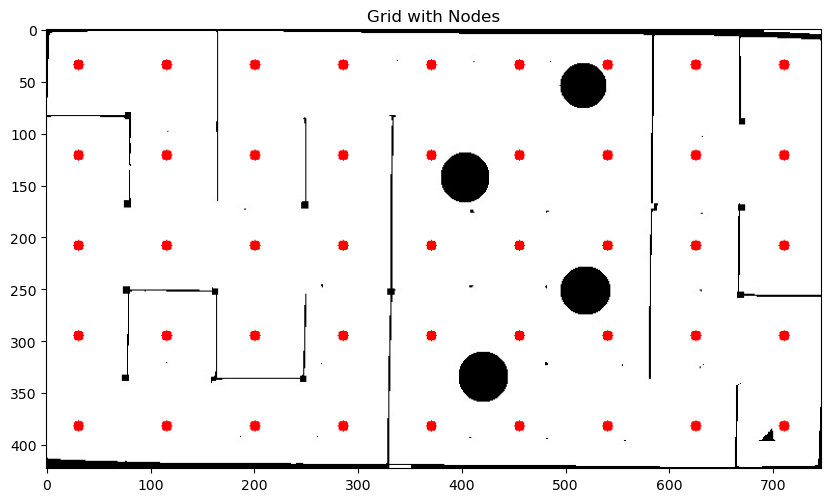

In [15]:
graph = Graph()

# Variable for path width
path_width = 3 

# Load the mask image (from the previous script)
# result_rgb = cv2.cvtColor(result, cv2.COLOR_GRAY2RGB)

# Load the mask image (only use this during debug)
mask = cv2.imread("mask_2.jpg")
result_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
result = result_rgb.copy()

def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting, selected_area
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = result_rgb.copy()
        cv2.rectangle(img_copy, start_point, end_point, (255, 0, 0), 2)
        cv2.imshow('Select Grid Area', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        selected_area = (start_point, end_point)
        print(f"Selected area: {selected_area}")

def create_grid(image_rgb, area, rows, cols):
    (start_x, start_y), (end_x, end_y) = area
    # Calculate grid cell size
    cell_width = (end_x - start_x) // (cols - 1)
    cell_height = (end_y - start_y) // (rows - 1)
    
    grid_image = image_rgb.copy()

    # Draw grid nodes as blue dots and create graph nodes
    for i in range(rows):
        for j in range(cols):
            x = start_x + j * cell_width
            y = start_y + i * cell_height
            cv2.circle(grid_image, (x, y), node_radius, (255, 0, 0), -1)
            graph.add_node((i, j), x, y)

    return grid_image, cell_width, cell_height

# Create a window and set the mouse callback
cv2.namedWindow('Select Grid Area')
cv2.setMouseCallback('Select Grid Area', mouse_callback)

# Display the mask image for selecting area
cv2.imshow('Select Grid Area', result_rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()

if 'selected_area' in globals():
    grid_image, cell_width, cell_height = create_grid(result_rgb, selected_area, rows, cols)
    
    # Display the final grid image with nodes
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_image)
    plt.title('Grid with Nodes')
    plt.show()
else:
    print("No area selected. Please run the selection process again.")

### Mark obstacle area

Selected area: ((336, 3), (578, 419))


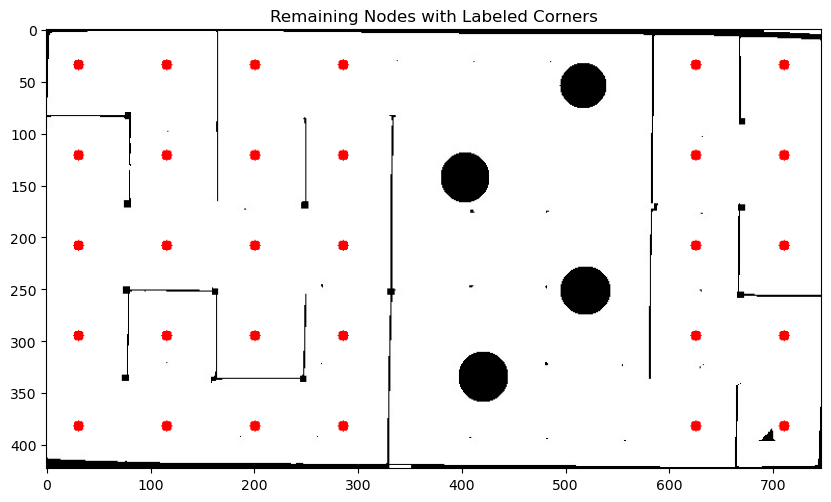

In [23]:
# Function to handle mouse callback for selecting area
def mouse_callback(event, x, y, flags, param):
    global start_point, end_point, selecting, selected_area
    if event == cv2.EVENT_LBUTTONDOWN:
        selecting = True
        start_point = (x, y)
    elif event == cv2.EVENT_MOUSEMOVE and selecting:
        end_point = (x, y)
        img_copy = grid_image.copy()
        cv2.rectangle(img_copy, start_point, end_point, (255, 0, 0), 2)
        cv2.imshow('Select Grid Area', img_copy)
    elif event == cv2.EVENT_LBUTTONUP:
        selecting = False
        end_point = (x, y)
        selected_area = (start_point, end_point)
        print(f"Selected area: {selected_area}")

# Create a window and set the mouse callback
cv2.namedWindow('Select Grid Area')
cv2.setMouseCallback('Select Grid Area', mouse_callback)

# Display the grid image for selecting area
cv2.imshow('Select Grid Area', grid_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# if 'selected_area' in globals():
(start_x, start_y), (end_x, end_y) = selected_area

# remove BFS nodes from area
nodes_within_area = []
for node in graph.nodes.values():
    x, y = node.get_point()
    if start_x <= x <= end_x and start_y <= y <= end_y:
        nodes_within_area.append((x, y))


# Remove nodes within the selected area
remaining_nodes = []
for node in graph.nodes.values():
    x, y = node.get_point()
    if (start_x <= x <= end_x and start_y <= y <= end_y):
        continue
        # if (x, y) not in corners:
        #     continue
    remaining_nodes.append((x, y))

# Create a copy of the original result image
result_with_nodes = result_rgb.copy()

# Draw the remaining nodes on the result image
for (x, y) in remaining_nodes:
    cv2.circle(result_with_nodes, (x, y), 5, (255, 0, 0), -1)

# draw rectangle over area
# cv2.rectangle(result_with_nodes, (start_x, start_y), (end_x, end_y), (0, 255, 0), 5)

# Display the result image with the remaining nodes and labeled corners
plt.figure(figsize=(10, 10))
plt.imshow(result_with_nodes)
plt.title('Remaining Nodes with Labeled Corners')
plt.show()

## Use PRM to pathfind through the continuous section.

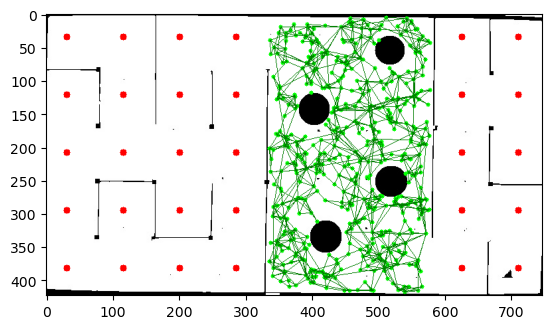

In [58]:
## PRM IMPLEMENTATION
import random
import math
seed = 42
iterations = 500
k_connections = 3
max_connection_range = 100
prm_image = result_with_nodes.copy()
prm_graph = Graph()
random.seed(seed)

def path_clear(image, x1, y1, x2, y2):
    rgbMax = 255
    from skimage.draw import line
    rr, cc = line(x1, y1, x2, y2)
    testLine = list(zip(rr,cc))
    for pixel in testLine:
        pixelX, pixelY = pixel
        for channel in image[pixelX, pixelY]:
            if channel != rgbMax:
                return False
    return True

def find_closest_nodes(image, graph, target_x, target_y, n, range):
        # nodes is a list of tuples (int node_id, double distance)
        nodes = []
        # loop through the whole graph and grab nodes within range. Sort and return n closest.
        for node in graph.get_nodes():
            nodeX, nodeY = graph.nodes[node].get_point()
            distance = math.sqrt((target_x - nodeX) ** 2 + (target_y - nodeY) ** 2)
            # if distance <= range and distance != 0.0 and path_clear(image, nodeX, nodeY, target_x, target_y):
            if distance <= range and distance != 0.0:
                if path_clear(image, nodeX, nodeY, target_x, target_y):
                    nodes.append((graph.nodes[node].get_ID(), distance))
        
        closestNodes = sorted(nodes, key=lambda node: node[1])
        return closestNodes[:n]

(start_x, start_y), (end_x, end_y) = selected_area
# print('exes: ', start_x, end_x)
# print('whys: ', start_y, end_y)

i = 0
while i < iterations:
    x = random.randint(start_x, end_x)
    y = random.randint(start_y, end_y)

    # my own coordinates are reversed from the provided ones, so swap them
    x, y = y, x
    # print('iter:', i, 'curr coords: ', x, y)

    # check if node is in free space - if colliding with an obstacle, skip this iteration
    nodeCollision = False
    for channel in prm_image[x, y]:
        if channel != 255:
            nodeCollision = True
    if nodeCollision:
        continue

    # if all good, then add this node with iteration count as id to the graph.
    prm_graph.add_node(i, x, y)
    # cv2.circle(prm_image, (x, y), 3, (0, 255, 0), -1)

    # draw straight lines to n closest nodes. If path clear, add edge to graph.
    # find_closest_nodes guarantees that the paths returned are all clear, so no need to recheck.
    closestNodes = find_closest_nodes(prm_image, prm_graph, x, y, k_connections, max_connection_range)
    # print(closestNodes)
    for node in closestNodes:
        nodeId, nodeDist = node
        nodeX, nodeY = prm_graph.nodes[nodeId].get_point()
        # 'i' is id of searching node, 'nodeId' is id of found node. 
        prm_graph.add_edge(i, nodeId, nodeDist)

    i += 1

# draw all nodes and edges on image
for node in prm_graph.get_nodes():
    x, y = prm_graph.nodes[node].get_point()
    id = node
    cv2.circle(prm_image, (y, x), 3, (0, 255, 0), -1)

for edgeStart in prm_graph.edges.keys():
    # print(edgeStart, ': ', prm_graph.edges[edgeStart])
    startX, startY = prm_graph.nodes[edgeStart].get_point()

    for edge in prm_graph.edges[edgeStart]:
        edgeEnd, dist = edge
        endX, endY = prm_graph.nodes[edgeEnd].get_point()
        cv2.line(prm_image, (startY, startX), (endY, endX), (0, 125, 0), 1)

# Display resulting image
plt.imshow(prm_image)
plt.show()